In [147]:
import sys
sys.path.append('../../')

from tqdm import tqdm

import torch as tc
import numpy as np
import matplotlib.pyplot as plt

from rcgp.rcgp import SpatioTemporalRCGP
from data.simulations import spatio_temporal_half_contaminated

plt.rc('font', family='serif', size=16)
plt.rcParams['text.usetex'] = True

In [ ]:
#seeds used for experiment are : 2, 4, 8, 16, 32

In [116]:
ts, grids, Ys, true_Ys, Ys_no_outliers, outliers_loc, n_lon, n_lat, lon_norm, lat_norm = spatio_temporal_half_contaminated(seed=2, outlier_proportion=0.15)

In [121]:
idx_reset = [0, 1, 3, 4, 5, 7, 8, 9]
Ys[idx_reset] = Ys_no_outliers[idx_reset].clone()

In [122]:
def regular_scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor):

    S = covs + R
    eps = Ys - preds

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)
    
    return energies.sum()

def weighted_scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor):

    S = covs + R
    eps = Ys - preds

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)

    weights = Ws.quantile(q=0.05, dim=1).flatten()
    #weights = Ws.mean(axis=1).flatten()
    weights = weights / weights.sum()

    return tc.dot(energies, weights)


In [123]:
def plot(grid, ts, Ys, Ys_no_outliers, outliers_loc, true_Ys, n_lon, n_lat, pred=None):

    x,y = grid[:, 0], grid[:, 1]
    X = x.reshape(n_lon, n_lat)
    Y = y.reshape(n_lon, n_lat)
    
    
    fig, axs = plt.subplots(len(ts), 3, figsize=(6, 20))
    kwargs = {"levels" : np.linspace(-5, 5, 20), "cmap": "YlGnBu"}

    for idx in range(len(ts)):
        if pred is not None: pred_plot = pred[idx].reshape(n_lon, n_lat)
        Ys_plot = Ys[idx].reshape(n_lon, n_lat)
        Ys_no_outliers_plot = Ys_no_outliers[idx].reshape(n_lon, n_lat)
        true_Ys_plot = true_Ys[idx].reshape(n_lon, n_lat)

        outliers_loc_t_plot = outliers_loc[np.where(np.isclose(outliers_loc[:, 0], ts[idx]))]

        if pred is None : 
            axs[idx, 0].contourf(X, Y, Ys_plot, **kwargs)
            axs[idx,1].contourf(X, Y, Ys_no_outliers_plot, **kwargs)

        else:
            axs[idx, 0].contourf(X, Y, pred_plot, **kwargs)
            axs[idx,1].contourf(X, Y, Ys_plot, **kwargs)

        #axs[idx, 1].scatter(outliers_loc_t_plot[:, 1], outliers_loc_t_plot[:, 2], marker='.', s=30., color='red')
        axs[idx, 2].contourf(X, Y, true_Ys_plot, **kwargs)
    
    if pred is None:
        axs[0,0].set_title("Contaminated Data")
        axs[0,1].set_title("Original Data")
        
    else:
        axs[0,0].set_title("Prediction")
        axs[0,1].set_title("Contaminated Data")

    
    axs[0,2].set_title("True Latent Function")

    #print("Mean Absolute Difference (Data - No Outliers) : ", np.abs(Ys_no_outliers - true_Ys).sum().item())
    #print("Mean Absolute Difference (Prediction) : ", np.abs(pred - true_Ys).sum().item())

    return

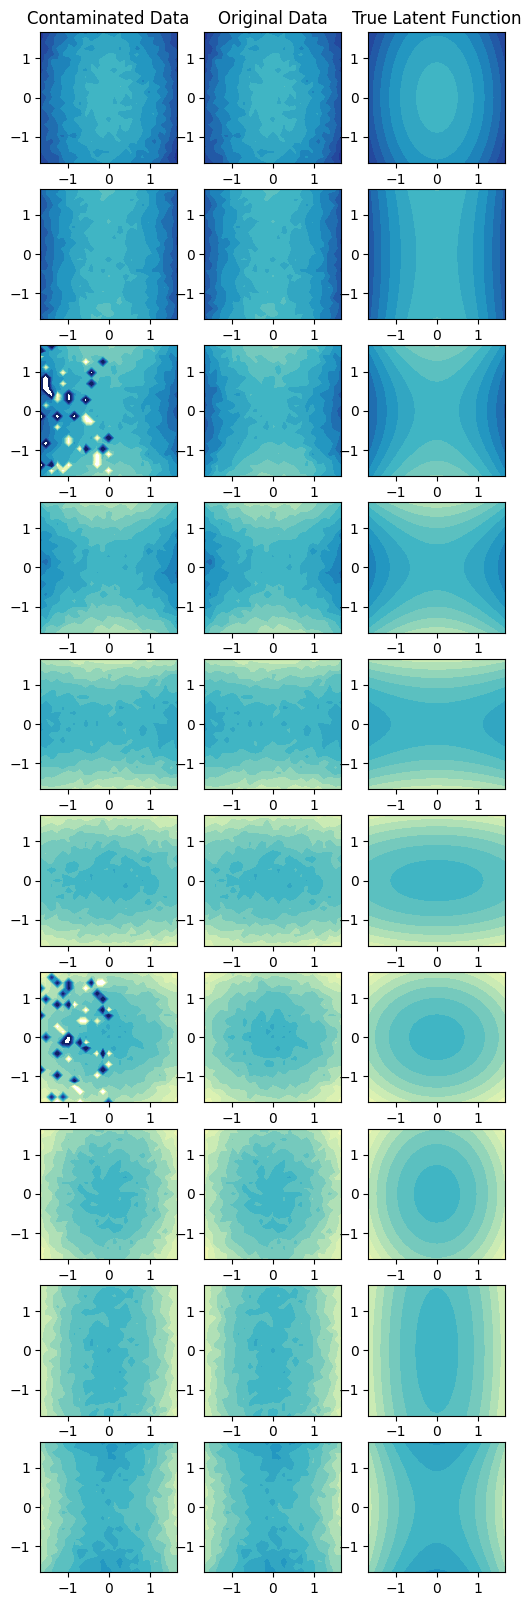

In [124]:
plot(grid=grids[0], ts=ts, Ys=Ys, Ys_no_outliers=Ys_no_outliers, outliers_loc=outliers_loc, true_Ys=true_Ys, n_lon=n_lon, n_lat=n_lat)

In [125]:
def plot_weights(grid, n_lon, n_lat, Ws, Ys, ts):

    x,y = grid[:, 0], grid[:, 1]
    X = x.reshape(n_lon, n_lat)
    Y = y.reshape(n_lon, n_lat)

    fig, axs = plt.subplots(len(ts), 2, figsize=(6, 20))
    kwargs = {"levels" : np.linspace(-5, 5, 20), "cmap": "YlGnBu"}

    for idx in range(len(ts)):
        Ws_plot = Ws[idx].reshape(n_lon, n_lat)
        Ys_plot = Ys[idx].reshape(n_lon, n_lat)

        
        axs[idx, 0].contourf(X, Y, Ws_plot * 1e4, **kwargs)
        axs[idx,1].contourf(X, Y, Ys_plot, **kwargs)

    axs[0,0].set_title("Weights")
    axs[0,1].set_title("Contaminated Data")


100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


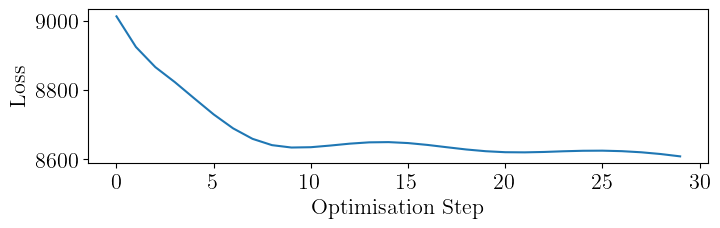

In [184]:
robust_loss = False

gp = SpatioTemporalRCGP(ts=ts, grid=grids[0], Ys=Ys, p=1)

gp.activate_robustness(func="m_pred") 
gp.adaptive_c()

losses = []
n_steps = 30
lr = 0.1

optimizer = tc.optim.Adam(gp.parameters(), lr=lr)

for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = gp.forward(smoothing=False)

    if robust_loss:
        loss = weighted_scoring_rule(Ys=Ys, preds=preds, covs=covs, R=R, Ws=Ws)
    else:
        loss = regular_scoring_rule(Ys=Ys, preds=preds, covs=covs, R=R, Ws=Ws)

    loss.backward()
    losses.append(loss.clone().detach())

    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [185]:
print("---Likelihood Variance----")
print(gp.var_y.clone().detach().item())
print("\n----Spatial Lengthscale, Magnitude-----")
print(gp.spatial_lengthscale.clone().detach().item(), gp.spatial_magnitude.clone().detach().item())
print("\n----Temporal Lengthscale, Magnitude----")
print(gp.temporal_lengthscale.clone().detach().item(), gp.temporal_magnitude.clone().detach().item())

---Likelihood Variance----
0.7474300265312195

----Spatial Lengthscale, Magnitude-----
1.2432540655136108 1.9808757305145264

----Temporal Lengthscale, Magnitude----
0.6623673439025879 1.9808268547058105


In [186]:
with tc.no_grad():
    (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = gp.forward(smoothing=True)

In [187]:
cum_diff = 0
for i in range(10):
    diff = (preds_smooth[i] - true_Ys[i].flatten()).abs().mean()
    cum_diff += diff
    print(f"{i}th row : ", diff)

print("Cumulative Difference : ", cum_diff)

#0.3338 is "very good" (with no outliers and regular opt obj)


#Need to beat 6.02 (weighted with avg)1

0th row :  tensor(0.3297)
1th row :  tensor(0.1829)
2th row :  tensor(0.1420)
3th row :  tensor(0.1459)
4th row :  tensor(0.1199)
5th row :  tensor(0.1926)
6th row :  tensor(0.1022)
7th row :  tensor(0.1528)
8th row :  tensor(0.2102)
9th row :  tensor(0.4191)
Cumulative Difference :  tensor(1.9974)


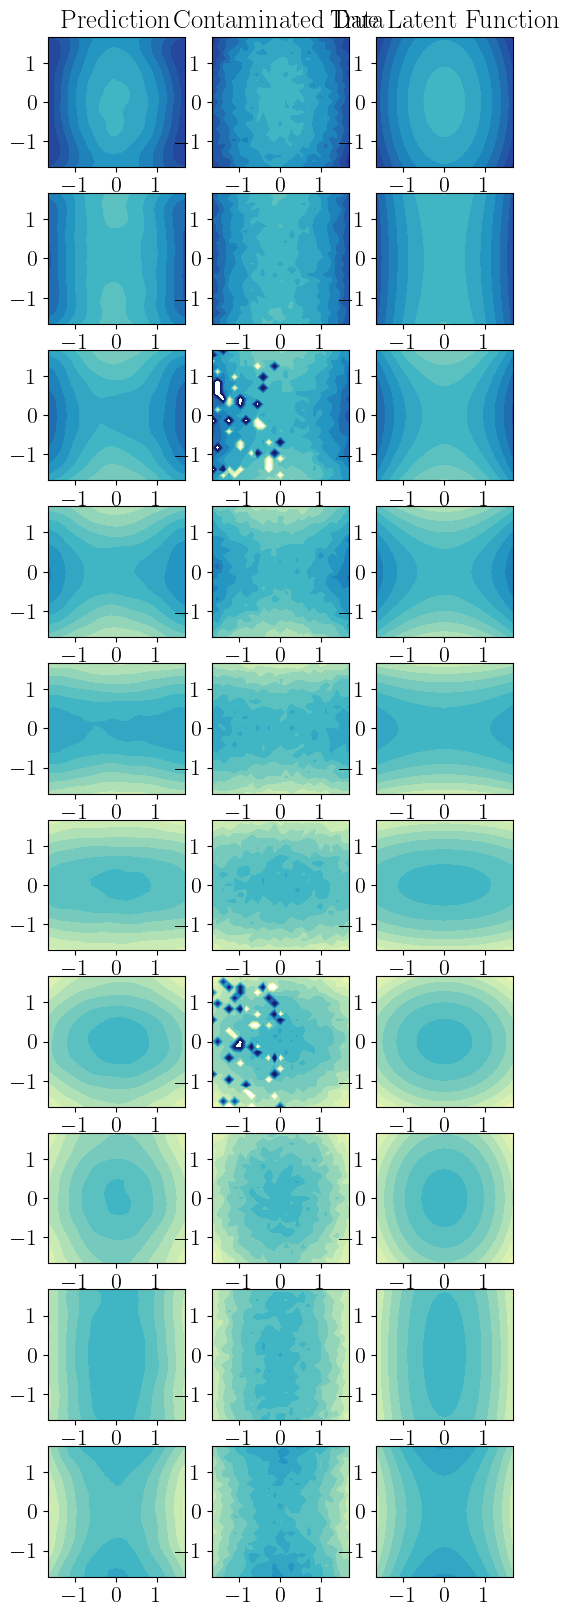

In [188]:
plot(grid=grids[0], ts=ts, Ys=Ys, Ys_no_outliers=Ys_no_outliers, outliers_loc=outliers_loc, true_Ys=true_Ys, n_lon=n_lon, n_lat=n_lat, pred=preds_smooth)

In [191]:
def plot_subgrid(grid, idx_list, ts, Ys, Ys_no_outliers, outliers_loc, true_Ys, n_lon, n_lat, robust_loss, pred=None, save=False):

    x,y = grid[:, 0], grid[:, 1]
    X = x.reshape(n_lon, n_lat)
    Y = y.reshape(n_lon, n_lat)
    
    
    fig, axs = plt.subplots(len(idx_list), 3, figsize=(8,8))
    kwargs = {"levels" : np.linspace(-6, 9, 20), "cmap": "YlGnBu"}

    for i, idx in enumerate(idx_list):
        if pred is not None: pred_plot = pred[idx].reshape(n_lon, n_lat)
        Ys_plot = Ys[idx].reshape(n_lon, n_lat)
        Ys_no_outliers_plot = Ys_no_outliers[idx].reshape(n_lon, n_lat)
        true_Ys_plot = true_Ys[idx].reshape(n_lon, n_lat)

        outliers_loc_t_plot = outliers_loc[np.where(np.isclose(outliers_loc[:, 0], ts[idx]))]

        if pred is None : 
            axs[i, 0].contourf(X, Y, Ys_plot, **kwargs)
            axs[i,1].contourf(X, Y, Ys_no_outliers_plot, **kwargs)

        else:
            axs[i, 0].contourf(X, Y, pred_plot, **kwargs)
            axs[i,1].contourf(X, Y, Ys_plot, **kwargs)

        #axs[idx, 1].scatter(outliers_loc_t_plot[:, 1], outliers_loc_t_plot[:, 2], marker='.', s=30., color='red')
        axs[i, 2].contourf(X, Y, true_Ys_plot, **kwargs)

        axs[i, 0].set_ylabel("t={:.2f}".format(ts[idx].item()), rotation=0, labelpad=20)
    
    if pred is None:
        axs[0,0].set_title("Contaminated Data")
        axs[0,1].set_title("Original Data")
        
    else:
        axs[0,0].set_title("Prediction")
        axs[0,1].set_title("Data")

    
    axs[0,2].set_title("Latent Function")

    if robust_loss:
        fig.suptitle(r"$\varphi_\textrm{\small GB}$", fontsize=28)
        if save:
            fig.savefig("./st-rcgp-spatio-temporal-fitting-outliers-GB-obj.pdf", format='pdf', bbox_inches='tight')

    else:
        fig.suptitle(r"$\varphi$", fontsize=28)
        if save:
            fig.savefig("./st-rcgp-spatio-temporal-fitting-outliers-regular-obj.pdf", format='pdf', bbox_inches='tight')



    #print("Mean Absolute Difference (Data - No Outliers) : ", np.abs(Ys_no_outliers - true_Ys).sum().item())
    #print("Mean Absolute Difference (Prediction) : ", np.abs(pred - true_Ys).sum().item())


    return

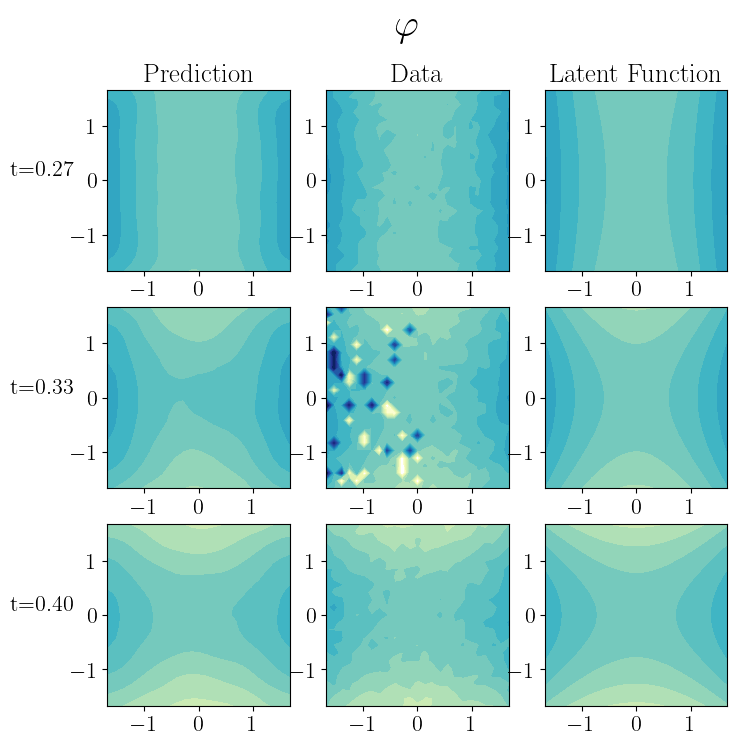

In [192]:
plot_subgrid(grid=grids[0],
             idx_list=[1,2,3],
             ts=ts, 
             Ys=Ys, 
             Ys_no_outliers=Ys_no_outliers, 
             outliers_loc=outliers_loc, 
             true_Ys=true_Ys, 
             n_lon=n_lon, 
             n_lat=n_lat, 
             pred=preds_smooth, 
             robust_loss=robust_loss,
             save=False)

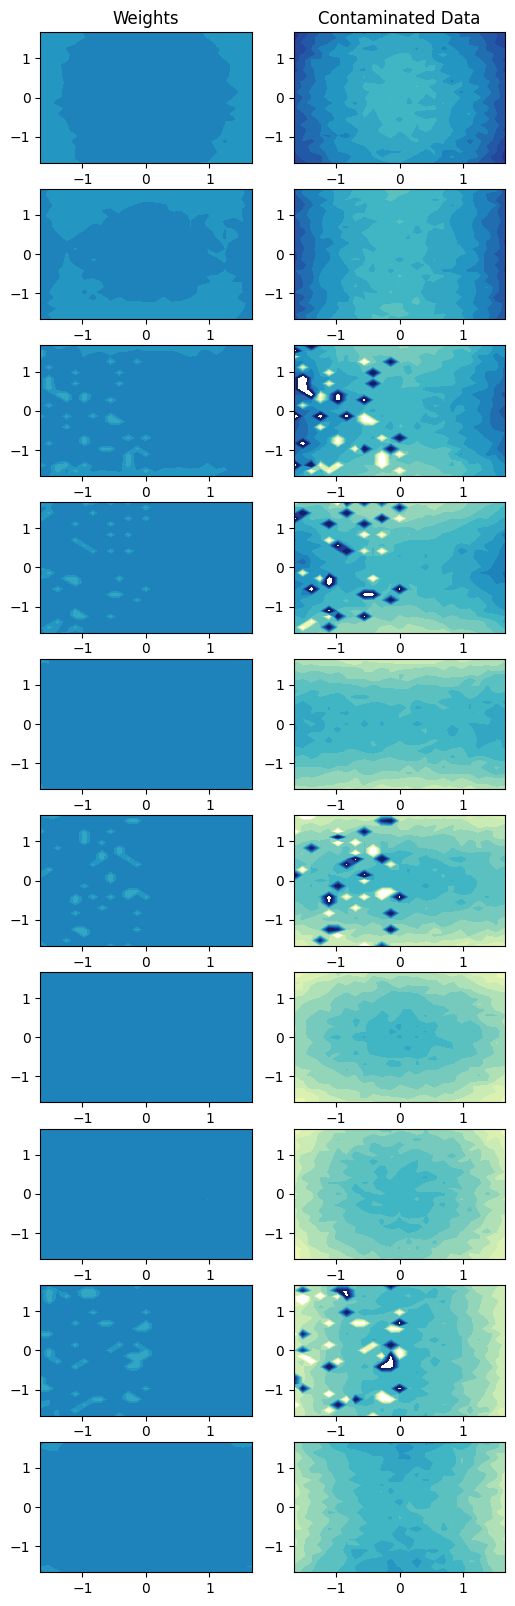

In [83]:
plot_weights(grid=grids[0], n_lat=n_lat, n_lon=n_lon, Ws=Ws_norm, Ys=Ys, ts=ts)